Лабораторна робота 1.3: Логістична регресія для задач класифікації
Варіант 2: Розпізнавання рукописних цифр (MNIST Digits)
Опис: Класифікація рукописних цифр від 0 до 9.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

# Сигмоїдна функція
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Обчислення вихідних значень моделі
def compute_model_output(X, w, b):
    z = np.dot(X, w) + b
    return sigmoid(z)

# Обчислення функції вартості
def compute_cost(X, y, w, b, lambda_=0):
    m = X.shape[0]
    f_wb = compute_model_output(X, w, b)

    # Запобігання помилкам при обчисленні логарифму
    f_wb = np.maximum(f_wb, 1e-15)
    f_wb = np.minimum(f_wb, 1 - 1e-15)

    cost = -1/m * np.sum(y * np.log(f_wb) + (1 - y) * np.log(1 - f_wb))

    # Додаємо регуляризацію, якщо lambda_ > 0
    if lambda_ > 0:
        reg_cost = lambda_ / (2 * m) * np.sum(w**2)
        cost += reg_cost

    return cost

# Обчислення градієнту
def compute_gradient(X, y, w, b, lambda_=0):
    m, n = X.shape
    f_wb = compute_model_output(X, w, b)

    dj_dw = 1/m * np.dot(X.T, (f_wb - y))
    dj_db = 1/m * np.sum(f_wb - y)

    # Додаємо регуляризацію, якщо lambda_ > 0
    if lambda_ > 0:
        dj_dw += (lambda_ / m) * w

    return dj_dw, dj_db

# Градієнтний спуск
def gradient_descent(X, y, w_init, b_init, alpha, num_iters, lambda_=0):
    w = w_init
    b = b_init
    J_history = []

    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient(X, y, w, b, lambda_)

        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        J_history.append(compute_cost(X, y, w, b, lambda_))

        if i % (num_iters // 10) == 0:
            print(f"Iteration {i}: Cost {J_history[-1]}")

    return w, b, J_history

# Передбачення класів
def predict(X, w, b):
    f_wb = compute_model_output(X, w, b)
    return (f_wb >= 0.5).astype(int)

# Обчислення точності
def compute_accuracy(X, y, w, b):
    predictions = predict(X, w, b)
    return np.mean(predictions == y) * 100

Форма X: (1797, 64)
Форма y: (1797,)


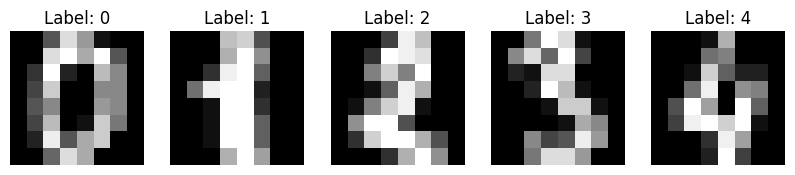

X_train: (252, 64)
X_test: (108, 64)
y_train: (252,)
y_test: (108,)


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Завантаження даних
digits = load_digits()

# Вивід інформації про дані
print("Форма X:", digits.data.shape)
print("Форма y:", digits.target.shape)

# Візуалізація перших 5 зображень
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f"Label: {digits.target[i]}")
    ax.axis('off')
plt.show()

# 2. Підготовка: виберемо лише два класи для бінарної класифікації (наприклад, '0' та '1')
mask = (digits.target == 0) | (digits.target == 1)
X = digits.data[mask]
y = digits.target[mask]

# 3. Масштабування ознак (нормалізація)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Розбиття на тренувальні та тестові дані
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Перевірка розмірів
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_model_output(X, w, b):
    return sigmoid(np.dot(X, w) + b)

def compute_cost(X, y, w, b, lambda_=0):
    m = X.shape[0]
    f_wb = compute_model_output(X, w, b)
    f_wb = np.clip(f_wb, 1e-15, 1 - 1e-15)
    cost = -1/m * np.sum(y * np.log(f_wb) + (1 - y) * np.log(1 - f_wb))
    cost += (lambda_ / (2 * m)) * np.sum(w**2)
    return cost

def compute_gradient(X, y, w, b, lambda_=0):
    m = X.shape[0]
    f_wb = compute_model_output(X, w, b)
    error = f_wb - y
    dj_dw = (1/m) * np.dot(X.T, error) + (lambda_ / m) * w
    dj_db = (1/m) * np.sum(error)
    return dj_dw, dj_db

def gradient_descent(X, y, w_init, b_init, alpha, num_iters, lambda_=0):
    w = w_init.copy()
    b = b_init
    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient(X, y, w, b, lambda_)
        w -= alpha * dj_dw
        b -= alpha * dj_db
    return w, b


In [8]:
def one_vs_all_train(X, y, num_labels, alpha=0.1, num_iters=300, lambda_=0.01):
    m, n = X.shape
    all_w = np.zeros((num_labels, n))
    all_b = np.zeros(num_labels)

    for c in range(num_labels):
        print(f"Тренування для класу {c}...")
        y_c = (y == c).astype(int)
        w_init = np.zeros(n)
        b_init = 0
        w, b = gradient_descent(X, y_c, w_init, b_init, alpha, num_iters, lambda_)
        all_w[c] = w
        all_b[c] = b

    return all_w, all_b


In [13]:
def one_vs_all_predict(X, all_w, all_b):
    scores = np.dot(X, all_w.T) + all_b
    probs = sigmoid(scores)
    return np.argmax(probs, axis=1)

In [14]:
num_labels = 10  # Цифри від 0 до 9

# Навчання
all_w, all_b = one_vs_all_train(X_train, y_train, num_labels, alpha=0.1, num_iters=500, lambda_=0.1)

# Передбачення
y_pred_train = one_vs_all_predict(X_train, all_w, all_b)
y_pred_test = one_vs_all_predict(X_test, all_w, all_b)

# Точність
train_acc = np.mean(y_pred_train == y_train) * 100
test_acc = np.mean(y_pred_test == y_test) * 100

print(f"Train Accuracy: {train_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")


Тренування для класу 0...
Тренування для класу 1...
Тренування для класу 2...
Тренування для класу 3...
Тренування для класу 4...
Тренування для класу 5...
Тренування для класу 6...
Тренування для класу 7...
Тренування для класу 8...
Тренування для класу 9...
Train Accuracy: 100.00%
Test Accuracy: 100.00%


Реалізація багатокласової логістичної регресії (One-vs-All)

In [19]:
def one_vs_all(X, y, all_w_init, all_b_init, alpha, num_iters, lambda_):
    n_classes = 10
    all_w = all_w_init.copy()
    all_b = all_b_init.copy()

    for digit in range(n_classes):
        print(f"Навчаємо класифікатор для класу {digit}...")
        y_binary = (y == digit).astype(int)  # Перетворюємо в 0 або 1
        w = all_w[digit]
        b = all_b[digit]

        w, b, _ = gradient_descent(X, y_binary, w, b, alpha, num_iters, lambda_)
        all_w[digit] = w
        all_b[digit] = b

    return all_w, all_b

def predict_multiclass(X, all_w, all_b):
    probs = np.zeros((X.shape[0], 10))
    for digit in range(10):
        probs[:, digit] = compute_model_output(X, all_w[digit], all_b[digit])
    return np.argmax(probs, axis=1)


Навчання та тестування моделі

In [27]:
# Встановлюємо параметри
alpha = 0.1         # швидкість навчання
num_iters = 1000    # кількість ітерацій
lambda_ = 0.1       # регуляризація

# Ініціалізація вагів і зміщення
n = X_train.shape[1]
all_w_init = np.zeros((10, n))
all_b_init = np.zeros(10)

# Навчання
all_w, all_b = one_vs_all(X_train, y_train, all_w_init, all_b_init, alpha, num_iters, lambda_)

# Передбачення
train_preds = predict_multiclass(X_train, all_w, all_b)
test_preds = predict_multiclass(X_test, all_w, all_b)

# Обчислення точності
train_accuracy = np.mean(train_preds == y_train) * 100
test_accuracy = np.mean(test_preds == y_test) * 100

print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Якщо хочеш побачити приклади неправильних передбачень:
import matplotlib.pyplot as plt

wrong_idxs = np.where(test_preds != y_test)[0]

if len(wrong_idxs) > 0:
    plt.figure(figsize=(10, 4))
    for i, idx in enumerate(wrong_idxs[:10]):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X_test[idx].reshape(8, 8), cmap='gray')
        plt.title(f"Pred: {test_preds[idx]}\nTrue: {y_test[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Модель класифікує всі тестові приклади правильно!")


Train Accuracy: 100.00%
Test Accuracy: 100.00%
Модель класифікує всі тестові приклади правильно!


Оцінка точності.

In [23]:
# Імпортуємо необхідні бібліотеки
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Завантажуємо дані (наприклад, набір даних Iris)
data = load_iris()
X = data.data
y = data.target

# Для задачі бінарної класифікації вибираємо лише два класи
X = X[y != 2]  # залишаємо лише два класи (0 і 1)
y = y[y != 2]

# Поділяємо дані на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Створюємо модель логістичної регресії
model = LogisticRegression()

# Навчаємо модель
model.fit(X_train, y_train)

# Отримуємо передбачення
y_pred = model.predict(X_test)

# Оцінка точності
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Precision, Recall, F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0



Візуалізацією меж прийняття рішень (за допомогою PCA).

Accuracy: 1.0


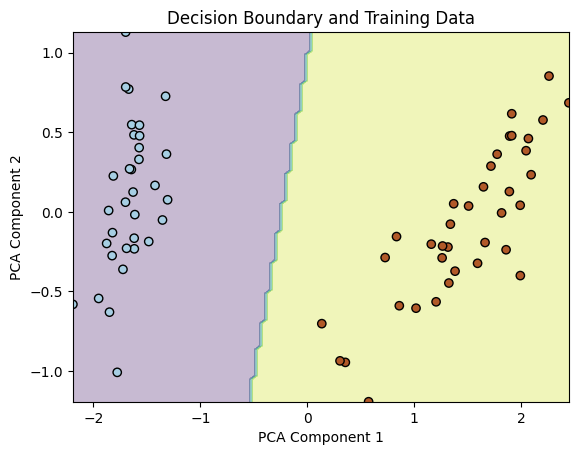

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Завантажуємо дані (наприклад, набір даних Iris)
data = load_iris()
X = data.data
y = data.target

# Для задачі бінарної класифікації вибираємо лише два класи
X = X[y != 2]  # залишаємо лише два класи (0 і 1)
y = y[y != 2]

# Поділяємо дані на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Застосовуємо PCA для зменшення розмірності до 2 компонент
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Створюємо та навчаємо модель логістичної регресії
model = LogisticRegression()
model.fit(X_train_pca, y_train)

# Отримуємо передбачення
y_pred = model.predict(X_test_pca)

# Оцінка точності
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Візуалізація межі прийняття рішень
# Створюємо сітку точок для побудови межі
xx, yy = np.meshgrid(np.linspace(X_train_pca[:, 0].min(), X_train_pca[:, 0].max(), 100),
                     np.linspace(X_train_pca[:, 1].min(), X_train_pca[:, 1].max(), 100))

# Передбачення класів для кожної точки сітки
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Візуалізація
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
plt.title("Decision Boundary and Training Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


Інтерактивний інтерфейс (ipywidgets).

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from ipywidgets import interactive

# Завантажуємо дані (наприклад, набір даних Iris)
data = load_iris()
X = data.data
y = data.target

# Для задачі бінарної класифікації вибираємо лише два класи
X = X[y != 2]  # залишаємо лише два класи (0 і 1)
y = y[y != 2]

# Поділяємо дані на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Застосовуємо PCA для зменшення розмірності до 2 компонент
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Створюємо функцію для навчання та візуалізації
def plot_decision_boundary(alpha=0.01, max_iter=1000, C=1.0):
    # Створюємо та навчаємо модель логістичної регресії
    model = LogisticRegression(C=C, max_iter=max_iter)
    model.fit(X_train_pca, y_train)

    # Отримуємо передбачення
    y_pred = model.predict(X_test_pca)

    # Візуалізація межі прийняття рішень
    # Створюємо сітку точок для побудови межі
    xx, yy = np.meshgrid(np.linspace(X_train_pca[:, 0].min(), X_train_pca[:, 0].max(), 100),
                         np.linspace(X_train_pca[:, 1].min(), X_train_pca[:, 1].max(), 100))

    # Передбачення класів для кожної точки сітки
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Візуалізація
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
    plt.title(f"Decision Boundary (alpha={alpha}, max_iter={max_iter}, C={C})")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

# Створюємо інтерактивний інтерфейс
interactive_plot = interactive(plot_decision_boundary,
                               alpha=widgets.FloatSlider(value=0.01, min=0.001, max=0.1, step=0.001, description="Learning Rate (alpha):"),
                               max_iter=widgets.IntSlider(value=1000, min=100, max=5000, step=100, description="Max Iterations:"),
                               C=widgets.FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description="Regularization (C):"))
display(interactive_plot)


interactive(children=(FloatSlider(value=0.01, description='Learning Rate (alpha):', max=0.1, min=0.001, step=0…